In [1]:
import warnings
import datetime
import pandas as pd
import numpy as np
import datetime, os, random
from pathlib import Path

# scikit-learn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# tensorflow & keras modules
import tensorflow as tf                                                       # tf.keras.optimizers.Adam - use 'tf.' only when calling direct methods ~ tf 2.0+
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator       # convert dataframe to array to use in timeseries generator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# plotting & outputs
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from pprint import pprint

# supress warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
Event = 840030016

In [2]:
MIN_ADD = datetime.timedelta(seconds = 60)
HOUR_ADD = 60 * MIN_ADD
DAY_ADD = HOUR_ADD * 24 

In [3]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

In [4]:
dfSurvey=pd.read_csv('Survey.csv')
dfSurvey['Date']=pd.to_datetime(dfSurvey['Date'])
date_list=pd.DataFrame([pd.to_datetime((max(dfSurvey['Date'])-datetime.timedelta(days=x)).strftime('%Y-%m-%d')) for x in range((max(dfSurvey['Date'])-min(dfSurvey['Date'])).days)], columns=['Date'])
dfSurvey=date_list.merge(dfSurvey, how='left', on='Date').sort_values('Date')
dfSurvey=dfSurvey.ffill()
dfSurvey.dropna(inplace=True)
dfSurvey=dfSurvey.reset_index(drop=True)
dfSurvey

,Date,Latest,Survey,SurveyHigh,SurveyLow
0,2011-01-31,7.0,146.0,230.0,-5.0
1,2011-02-01,7.0,146.0,230.0,-5.0
2,2011-02-02,7.0,146.0,230.0,-5.0
3,2011-02-03,7.0,146.0,230.0,-5.0
4,2011-02-04,7.0,146.0,230.0,-5.0
...,...,...,...,...,...
4529,2023-06-26,306.0,195.0,250.0,100.0
4530,2023-06-27,306.0,195.0,250.0,100.0
4531,2023-06-28,306.0,195.0,250.0,100.0
4532,2023-06-29,306.0,195.0,250.0,100.0


In [5]:
dfMarketData = pd.read_csv('WDOFUTCandles.csv',',')
dfMarketData.columns = ['Datetime','Trades','Open','High','Low','Close','Volume','Quantity']
# dfMarketData['Datetime'] = dfMarketData['Date'].str.replace('.','-') + ' ' + dfMarketData['Time']
dfMarketData = dfMarketData[['Datetime','Open','High','Low','Close']]
dfMarketData['Returns'] = dfMarketData['Close'].pct_change()
dfMarketData['Datetime'] = pd.to_datetime(dfMarketData['Datetime'])
dfMarketData = dfMarketData.set_index('Datetime')
dfMarketData = dfMarketData.sort_index()
dfMarketData['RSI_2']=get_rsi(dfMarketData['Close'], 2)
dfMarketData['Date']=pd.to_datetime(dfMarketData.index.date)
dfMarketData=dfMarketData.reset_index().merge(dfSurvey,how='left',on='Date').set_index('Datetime')
dfMarketData.drop(columns=['Date'],inplace=True)
dfMarketData.dropna(inplace=True)
dfMarketData.tail()

,Open,High,Low,Close,Returns,RSI_2,Latest,Survey,SurveyHigh,SurveyLow
Datetime,,,,,,,,,,
2023-06-30 17:55:00,4822.5,4823.5,4819.0,4820.0,-0.000726,11.080559,209.0,230.0,350.0,110.0
2023-06-30 17:56:00,4820.0,4821.5,4818.5,4819.0,-0.000207,7.744843,209.0,230.0,350.0,110.0
2023-06-30 17:57:00,4819.5,4820.0,4818.0,4820.0,0.000208,42.415546,209.0,230.0,350.0,110.0
2023-06-30 17:58:00,4819.0,4819.0,4809.5,4810.0,-0.002075,4.980535,209.0,230.0,350.0,110.0
2023-06-30 17:59:00,4810.0,4814.0,4808.0,4811.0,0.000208,19.236539,209.0,230.0,350.0,110.0


In [6]:
# dfMarketData = pd.read_csv('WDODATA.csv','\t')
# dfMarketData.columns = ['Date','Time','Open','High','Low','Close','TickVol','Vol','Spread']
# dfMarketData['Datetime'] = dfMarketData['Date'].str.replace('.','-') + ' ' + dfMarketData['Time']
# dfMarketData = dfMarketData[['Datetime','Open','High','Low','Close']]
# dfMarketData['Returns'] = dfMarketData['Close'].pct_change()
# dfMarketData['Datetime'] = pd.to_datetime(dfMarketData['Datetime'])
# dfMarketData = dfMarketData.set_index('Datetime')
# dfMarketData = dfMarketData.sort_index()
# dfMarketData['RSI_2']=get_rsi(dfMarketData['Close'], 2)
# dfMarketData['Date']=pd.to_datetime(dfMarketData.index.date)
# dfMarketData=dfMarketData.reset_index().merge(dfSurvey,how='left',on='Date').set_index('Datetime')
# dfMarketData.drop(columns=['Date'],inplace=True)
# dfMarketData.tail()

In [7]:
dfEventsData = pd.read_csv('EventsData.csv')
dfEventsFromTo = pd.read_csv('EventsFromTo.csv')
dfEventsFromTo=dfEventsFromTo.set_index('EventID').T
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['Datetime'])
dfEventsData['PercentChng'] = dfEventsData['ActualValue'].pct_change()
dfEventsData['DummyChng'] = 0
dfEventsData.loc[dfEventsData['PercentChng']>0, 'DummyChng'] = 1
dfEventsData.loc[dfEventsData['PercentChng']<0, 'DummyChng'] = -1
dfEventsData['Date'] = dfEventsData['ReleaseTime'].apply(lambda x: datetime.datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
dfEventsData = dfEventsData.loc[dfEventsData['ReleaseTime'] > min(dfMarketData.index),:]
dfEventsData['Datetime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData = dfEventsData.set_index('Datetime')
dfEventsData = dfEventsData.sort_index()
dfEventsData = dfEventsData[dfEventsData['EventID']==Event][['ActualValue','PercentChng','DummyChng']]
dfEventsData = pd.merge(dfEventsData, dfMarketData[['Close','RSI_2','Survey']], how='inner', on='Datetime')
dfEventsData.columns = ['ActualValue','PercentChng','DummyChng','WdoPrice','WdoRsi2','Survey']
dfEventsData['WdoRsiBool'] = dfEventsData.apply(lambda x: 1 if x['WdoRsi2']>=70 or x['WdoRsi2']<=30 else 0, axis=1)
dfEventsData['AbsSurveyDiff']=dfEventsData['ActualValue']-dfEventsData['Survey']
dfEventsData['PctSurveyDiff']=dfEventsData['ActualValue']/dfEventsData['Survey']-1
dfEventsData.tail()

,ActualValue,PercentChng,DummyChng,WdoPrice,WdoRsi2,Survey,WdoRsiBool,AbsSurveyDiff,PctSurveyDiff
Datetime,,,,,,,,,
2022-11-04 09:30:00,261.0,-0.007605,-1,5354.760616,38.284897,193.0,0,68.0,0.352332
2022-12-02 10:30:00,263.0,0.007663,1,5438.823150,94.474322,200.0,1,63.0,0.315000
2023-01-06 10:30:00,223.0,-0.152091,-1,5532.422143,21.022909,205.0,1,18.0,0.087805
2023-02-03 10:30:00,517.0,1.318386,1,5258.445589,95.689114,189.0,1,328.0,1.735450
2023-03-10 10:30:00,311.0,-0.398453,-1,5319.213817,3.506310,225.0,1,86.0,0.382222


In [8]:
mins_to_check_before=[1,5]
dfEventsData['WdoMaxVarAfter']=0

for mins in mins_to_check_before:
    dfEventsData[f'WdoVar{str(mins)}MinBefore']=0
    dfEventsData[f'WdoMaxVar{str(mins)}MinBefore']=0

for idx, release in dfEventsData.iterrows():
        for mins in mins_to_check_before:
            mktdata_on_release = idx
            mktdata_pre_release = mktdata_on_release - MIN_ADD * mins
            df_mktdata_pre_release = dfMarketData[(dfMarketData.index <= mktdata_on_release) & (dfMarketData.index >= mktdata_pre_release)]
            if not df_mktdata_pre_release.empty:
                release_price = -1
                dfEventsData[f'WdoVar{str(mins)}MinBefore'][idx]=df_mktdata_pre_release['Close'][-1]-df_mktdata_pre_release['Open'][0]
                dfEventsData[f'WdoMaxVar{str(mins)}MinBefore'][idx]=(max(abs(df_mktdata_pre_release['Close'][-1]-max(df_mktdata_pre_release['High'])),abs(df_mktdata_pre_release['Close'][-1]-min(df_mktdata_pre_release['Low']))))

for idx, release in dfEventsData.iterrows():
        mktdata_on_release = idx
        mktdata_after_release = mktdata_on_release + MIN_ADD * 5
        df_mktdata_release = dfMarketData[(dfMarketData.index >= mktdata_on_release) & (dfMarketData.index <= mktdata_after_release)]
        if not df_mktdata_release.empty:
            release_price = -1
            try:
                release_price = df_mktdata_release['Open'][mktdata_on_release]
            except:
                try:
                    release_price = df_mktdata_release['Close'][mktdata_on_release - MIN_ADD]
                except:
                    print('ERROR')
            dfEventsData['WdoMaxVarAfter'][idx]=(max(abs(release_price-max(df_mktdata_release['High'])),abs(release_price-min(df_mktdata_release['Low']))))

In [9]:
dfEventsData.head()

,ActualValue,PercentChng,DummyChng,WdoPrice,WdoRsi2,Survey,WdoRsiBool,AbsSurveyDiff,PctSurveyDiff,WdoMaxVarAfter,WdoVar1MinBefore,WdoMaxVar1MinBefore,WdoVar5MinBefore,WdoMaxVar5MinBefore
Datetime,,,,,,,,,,,,,,
2012-10-05 09:30:00,148.0,0.042254,1,3947.475886,8.571946,115.0,1,33.0,0.286957,1,0,1,0,1
2012-12-07 10:30:00,161.0,0.166667,1,4016.726769,33.475995,85.0,0,76.0,0.894118,0,0,0,0,0
2013-01-04 10:30:00,196.0,0.217391,1,3939.692946,24.994577,152.0,1,44.0,0.289474,0,0,0,0,1
2013-02-01 10:30:00,119.0,-0.392857,-1,3813.108744,99.164806,165.0,1,-46.0,-0.278788,1,0,0,0,0
2013-03-08 10:30:00,268.0,1.252101,1,3726.375111,1.531862,165.0,1,103.0,0.624242,1,0,1,-1,1


In [10]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=1, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value <= .05
    df.columns = [str(var)+'_x' for var in variables]
    df.index = [str(var)+'_y' for var in variables]
    return df

# Feature Selection

In [11]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression, SelectKBest, SelectPercentile
from sklearn.feature_selection import RFECV, RFE
from sklearn import preprocessing

default_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])

In [12]:
y = 'WdoMaxVarAfter'
x = dfEventsData.columns
x=x.drop(y)

Y = dfEventsData[y]
X = dfEventsData[x]

In [13]:
# corr = X.corr()
# corr = corr.style.background_gradient(cmap='coolwarm')
# corr

In [14]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
ActualValue,117.0,141.863248,1995.948625,-20500.000000,161.000000,222.000000,282.000000,4800.000000
PercentChng,117.0,0.356763,3.052140,-8.909091,-0.333333,-0.035874,0.389163,28.243937
DummyChng,117.0,-0.076923,1.001325,-1.000000,-1.000000,-1.000000,1.000000,1.000000
WdoPrice,117.0,4901.320284,860.581423,3726.375111,4197.688587,4622.700430,5584.046964,6730.515229
WdoRsi2,117.0,43.937162,38.718477,0.097629,6.667884,30.304464,86.482673,99.974658
Survey,117.0,31.675214,2205.506279,-22000.000000,175.000000,193.000000,230.000000,3230.000000
WdoRsiBool,117.0,0.863248,0.345063,0.000000,1.000000,1.000000,1.000000,1.000000
AbsSurveyDiff,117.0,110.188034,955.488943,-734.000000,-40.000000,18.000000,73.000000,10009.000000
PctSurveyDiff,117.0,0.097007,0.829909,-3.800000,-0.186528,0.079755,0.322148,6.010000
WdoVar1MinBefore,117.0,-2.871795,13.753707,-36.000000,-11.000000,0.000000,2.000000,45.000000


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0, shuffle=False)

## Granger Causality

In [16]:
# Granger causality
grangers_causation_matrix(dfEventsData, dfEventsData.columns)

,ActualValue_x,PercentChng_x,DummyChng_x,WdoPrice_x,WdoRsi2_x,Survey_x,WdoRsiBool_x,AbsSurveyDiff_x,PctSurveyDiff_x,WdoMaxVarAfter_x,WdoVar1MinBefore_x,WdoMaxVar1MinBefore_x,WdoVar5MinBefore_x,WdoMaxVar5MinBefore_x
ActualValue_y,False,True,False,False,False,True,False,True,True,False,False,False,False,False
PercentChng_y,True,False,False,False,False,False,False,False,True,False,False,False,False,False
DummyChng_y,False,False,False,True,False,False,False,False,False,False,False,True,False,True
WdoPrice_y,True,True,False,False,False,True,False,False,False,False,False,False,False,False
WdoRsi2_y,False,False,False,False,False,False,False,False,False,True,False,True,False,True
Survey_y,True,False,False,False,False,False,False,True,True,False,False,False,False,False
WdoRsiBool_y,False,False,False,False,False,False,False,False,False,False,False,False,False,False
AbsSurveyDiff_y,True,True,False,False,False,True,True,False,False,False,False,False,False,False
PctSurveyDiff_y,False,False,False,False,False,False,False,False,False,False,False,False,False,False
WdoMaxVarAfter_y,False,False,True,True,False,False,False,False,False,False,False,False,False,False


In [17]:
# Granger causality
# label = WdoMaxVar
GrangerFeatures = ['DummyChng', 'WdoPrice']
GrangerX = X_train[GrangerFeatures]
GrangerFitted=default_pipe.fit(GrangerX, y_train)
R2Granger=GrangerFitted.score(X_test[GrangerX.columns], y_test)
print(f'R²: {R2Granger:0.4}')

R²: 0.004209


## VIF

In [18]:
def vif(dataframe):
    scaler = StandardScaler()
    xs = scaler.fit_transform(dataframe)
    vif = pd.DataFrame()
    vif["Features"] = dataframe.columns
    vif["VIF Factor"] = [variance_inflation_factor(xs, i) for i in range(xs.shape[1])]
    return vif

In [19]:
vif_df = vif(X_train).round(2)
vif_df=vif_df[vif_df['VIF Factor']<5]
vif_df

,Features,VIF Factor
1,PercentChng,1.65
2,DummyChng,1.78
3,WdoPrice,1.40
4,WdoRsi2,2.97
6,WdoRsiBool,1.19


In [20]:
# VIF
# label = WdoMaxVar
VIFFeatures = list(vif_df['Features'])
VIFX = X_train[VIFFeatures]
VIFFitted=default_pipe.fit(VIFX, y_train)
R2VIF=VIFFitted.score(X_test[VIFX.columns], y_test)
print(f'R²: {R2VIF:0.4}')

R²: -0.3128


## SelectKBest

In [21]:
skb_method =  SelectKBest(f_regression, k=3)
skb_method.fit(X_train, y_train)
# Iterate the score
vet = []
for f, s in zip(X.columns, skb_method.scores_):
    vet.append([s,f])
vet = pd.DataFrame(vet)
vet.columns = ['Scores', 'Features']
vet.sort_values('Scores',inplace=True)
vet

,Scores,Features
0,0.085466,ActualValue
7,0.488134,AbsSurveyDiff
8,1.116131,PctSurveyDiff
2,1.196588,DummyChng
1,1.283548,PercentChng
5,3.597967,Survey
6,5.139209,WdoRsiBool
3,7.729511,WdoPrice
4,7.846047,WdoRsi2
9,15.886604,WdoVar1MinBefore


In [22]:
# SKB
# label = WdoMaxVar
SKBFeatures = ['WdoMaxVar1MinBefore', 'WdoMaxVar5MinBefore']
SKBX = X_train[SKBFeatures]
SKBFitted=default_pipe.fit(SKBX, y_train)
R2SKB=SKBFitted.score(X_test[SKBX.columns], y_test)
print(f'R²: {R2SKB:0.4}')

R²: 0.4675


## RFE

In [23]:
rfe_method = RFE(LinearRegression(), n_features_to_select=3, step=1)
rfe_method.fit(X_train,y_train)
min_value = min(rfe_method.ranking_)
col = [i for i, x in enumerate(rfe_method.ranking_) if x == min_value]
rfe_result=list(X.columns[col])
rfe_result

['DummyChng', 'PctSurveyDiff', 'WdoMaxVar5MinBefore']

In [24]:
# RFE
# label = WdoMaxVar
RFEFeatures = rfe_result
RFEX = X_train[RFEFeatures]
RFEFitted=default_pipe.fit(RFEX, y_train)
R2RFE=RFEFitted.score(X_test[rfe_result], y_test)
print(f'R²: {R2RFE:0.4}')

R²: 0.3634


## RFECV

In [25]:
rfecv_method = RFECV(LinearRegression(), cv=3)
rfecv_method.fit(X_train,y_train)

RFECV(cv=3, estimator=LinearRegression())

In [26]:
min_value = min(rfecv_method.ranking_)
col = [i for i, x in enumerate(rfecv_method.ranking_) if x == min_value]
rfecv_result=list(X.columns[col])
rfecv_result

['PercentChng',
 'DummyChng',
 'WdoRsiBool',
 'PctSurveyDiff',
 'WdoVar1MinBefore',
 'WdoVar5MinBefore',
 'WdoMaxVar5MinBefore']

In [27]:
# RFECV
# label = WdoMaxVar
RFECVFeatures = rfecv_result
RFECVX = X_train[RFECVFeatures]
RFECVFitted=default_pipe.fit(RFECVX, y_train)
R2RFECV=RFECVFitted.score(X_train[RFECVFeatures], y_train)
print(f'R²: {R2RFECV}')

R²: 0.7763285105062787


## Original features

In [28]:
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
# fit/train model
OriginalFeatures=list(X_train.columns)
pipe.fit(X_train, y_train)
r2_orig = pipe.score(X_test, y_test)
print(f'R^2: {r2_orig}')

R^2: -235.77603377755358


## Comparison

In [29]:
r2_df = pd.DataFrame({'Original Features Set': [r2_orig], 'VIF': [R2VIF], 'SelectKBest': [R2SKB], 
                      'RFE': [R2RFE], 'RFECV': [R2RFECV], 'Granger': [R2Granger]})
r2_df.index = ['R²']
r2_df = r2_df.T
r2_df.sort_values(by='R²',inplace=True)
r2_df

,R²
Original Features Set,-235.776034
VIF,-0.312775
Granger,0.004209
RFE,0.363428
SelectKBest,0.467496
RFECV,0.776329


In [30]:
df_features= {
    'granger': GrangerFeatures,
    'vif':VIFFeatures,
    'skb': SKBFeatures,
    'rfecv':RFECVFeatures,
    'rfe':RFEFeatures,
    'original': OriginalFeatures
}
df_features

{'granger': ['DummyChng', 'WdoPrice'],
 'vif': ['PercentChng', 'DummyChng', 'WdoPrice', 'WdoRsi2', 'WdoRsiBool'],
 'skb': ['WdoMaxVar1MinBefore', 'WdoMaxVar5MinBefore'],
 'rfecv': ['PercentChng',
  'DummyChng',
  'WdoRsiBool',
  'PctSurveyDiff',
  'WdoVar1MinBefore',
  'WdoVar5MinBefore',
  'WdoMaxVar5MinBefore'],
 'rfe': ['DummyChng', 'PctSurveyDiff', 'WdoMaxVar5MinBefore'],
 'original': ['ActualValue',
  'PercentChng',
  'DummyChng',
  'WdoPrice',
  'WdoRsi2',
  'Survey',
  'WdoRsiBool',
  'AbsSurveyDiff',
  'PctSurveyDiff',
  'WdoVar1MinBefore',
  'WdoMaxVar1MinBefore',
  'WdoVar5MinBefore',
  'WdoMaxVar5MinBefore']}

In [31]:
# Choice is Select K Best
Features=RFECVFeatures

# Model

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,7)
plt.style.use('fivethirtyeight')

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
def model_report(X, y, model):
    # predictions
    y_pred = model.predict(X)
    df = pd.DataFrame({
        'actual': y,
        'prediction': y_pred.flatten()})
    df['spread'] = df['prediction'] - df['actual']
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    ax[0].plot(df.actual, color='red', label='actual')
    ax[0].plot(df.prediction, color='blue', label='prediction')
    ax[1].hist(df.spread, bins=50, density=True, label='spread')
    ax[0].legend()
    ax[1].legend()
    plt.suptitle(f'{model} Prediction');

In [34]:
ModelX_train=X_train[Features]
ModelX_test=X_test[Features]
Modely_train=y_train
Modely_test=y_test
ModelX=X[Features]
ModelY=Y

# LogReg

In [35]:
logRegPipe = Pipeline([('scaler', StandardScaler()), ('regressor', LogisticRegression())])
logRegPipe.fit(ModelX_train,Modely_train)
Modely_pred = logRegPipe.predict(ModelX)
mse = mean_squared_error(ModelY, Modely_pred)
rmse = np.sqrt(mse)
df_y_test=pd.DataFrame(Modely_test)
df_y_pred=pd.DataFrame(logRegPipe.predict(ModelX_test))
df_y_pred.index=df_y_test.index
logRegY_df=df_y_test.merge(df_y_pred,how='inner',on='Datetime')
logRegY_df.columns=['y_test','y_pred']
logRegY_df['diff']=logRegY_df['y_test']-logRegY_df['y_pred']
logRegY_df.head()

,y_test,y_pred,diff
Datetime,,,
2019-04-05 09:30:00,19,15,4
2019-05-03 09:30:00,12,3,9
2019-06-07 09:30:00,14,3,11
2019-07-05 09:30:00,18,3,15
2019-08-02 09:30:00,11,3,8


In [36]:
print(f'Total R²: {logRegPipe.score(ModelX, ModelY):.2f}\nTrain R²: {logRegPipe.score(ModelX_train, Modely_train):.2f}\nTest R²: {logRegPipe.score(ModelX_test, Modely_test):.2f}\nmse: {mse:.2f}\nrmse: {rmse}')

Total R²: 0.28
Train R²: 0.46
Test R²: 0.02
mse: 134.33
rmse: 11.590225767142474


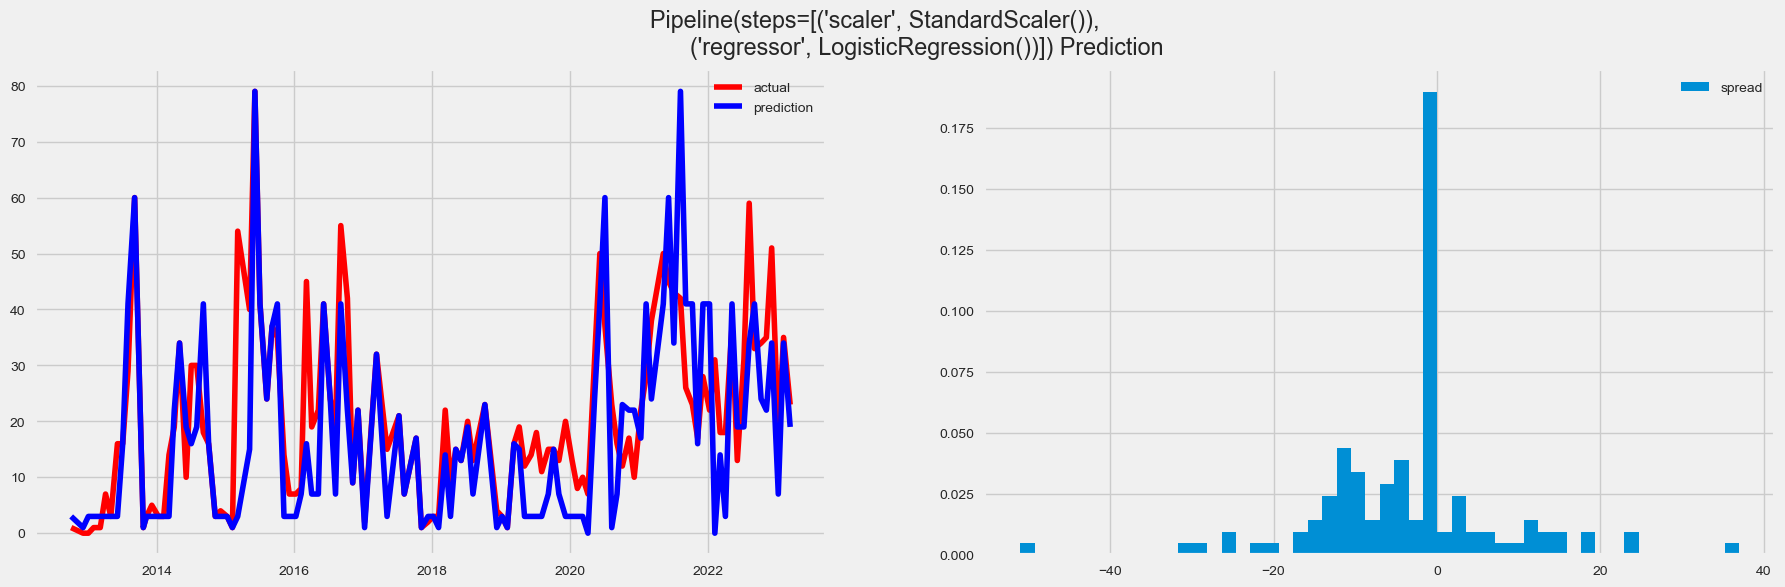

In [37]:
model_report(ModelX, ModelY, logRegPipe)

## KNeigh

In [38]:
kNeighPipe = Pipeline([('scaler', StandardScaler()), ('regressor', KNeighborsRegressor())])
kNeighPipe.fit(ModelX_train,Modely_train)
Modely_pred = kNeighPipe.predict(ModelX)
mse = mean_squared_error(ModelY, Modely_pred)
rmse = np.sqrt(mse)
df_y_test=pd.DataFrame(Modely_test)
df_y_pred=pd.DataFrame(kNeighPipe.predict(ModelX_test))
df_y_pred.index=df_y_test.index
kNeighY_df=df_y_test.merge(df_y_pred,how='inner',on='Datetime')
kNeighY_df.columns=['y_test','y_pred']
kNeighY_df['diff']=kNeighY_df['y_test']-kNeighY_df['y_pred']
kNeighY_df.head()

,y_test,y_pred,diff
Datetime,,,
2019-04-05 09:30:00,19,18.8,0.2
2019-05-03 09:30:00,12,6.0,6.0
2019-06-07 09:30:00,14,12.6,1.4
2019-07-05 09:30:00,18,8.0,10.0
2019-08-02 09:30:00,11,7.6,3.4


In [39]:
print(f'Total R²: {kNeighPipe.score(ModelX, ModelY):.2f}\nTrain R²: {kNeighPipe.score(ModelX_train, Modely_train):.2f}\nTest R²: {kNeighPipe.score(ModelX_test, Modely_test):.2f}\nmse: {mse:.2f}\nrmse: {rmse}')

Total R²: 0.54
Train R²: 0.67
Test R²: 0.11
mse: 113.74
rmse: 10.664951785226062


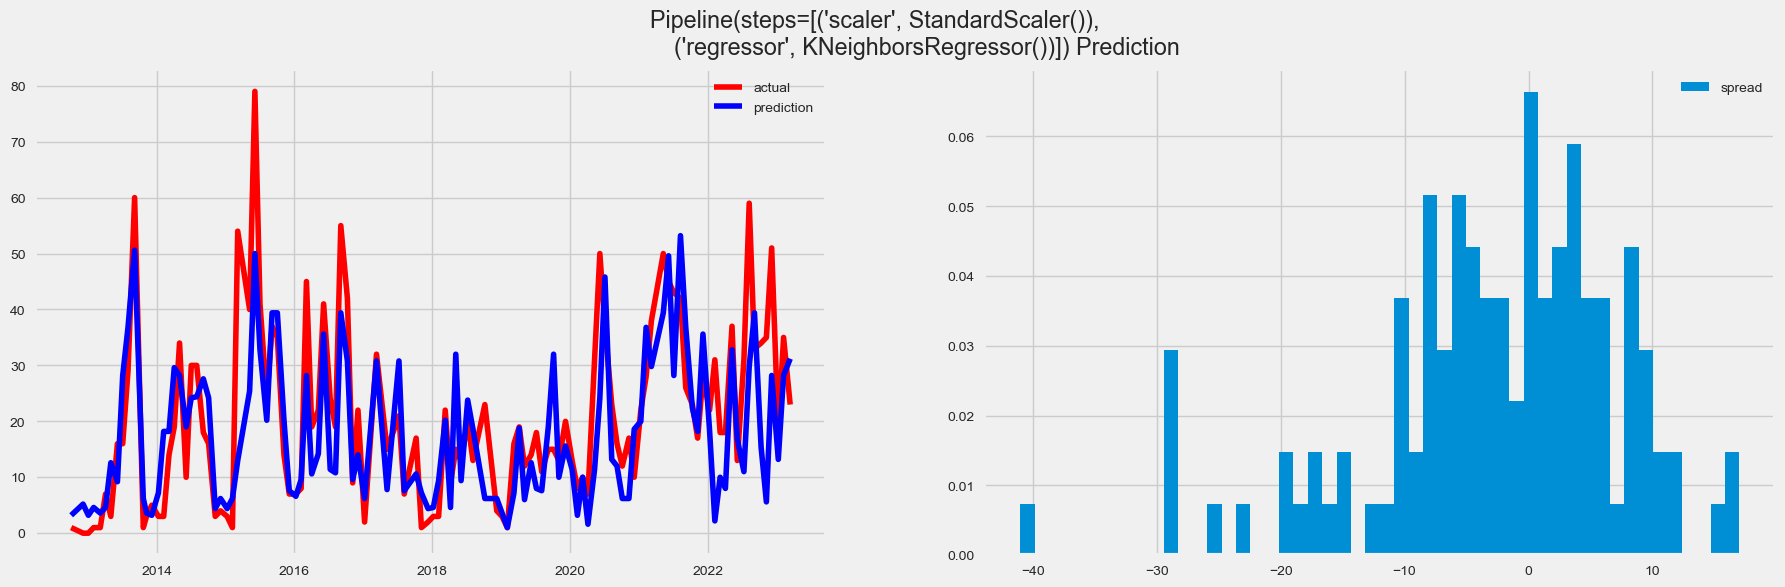

In [40]:
model_report(ModelX, ModelY, kNeighPipe)

## DecisionTreeClassifier

In [41]:
decisionTreePipe = Pipeline([('scaler', StandardScaler()), ('regressor', DecisionTreeRegressor())])
decisionTreePipe.fit(ModelX_train,Modely_train)
Modely_pred = decisionTreePipe.predict(ModelX)
mse = mean_squared_error(ModelY, Modely_pred)
rmse = np.sqrt(mse)
df_y_test=pd.DataFrame(Modely_test)
df_y_pred=pd.DataFrame(decisionTreePipe.predict(ModelX_test))
df_y_pred.index=df_y_test.index
decisionTreeY_df=df_y_test.merge(df_y_pred,how='inner',on='Datetime')
decisionTreeY_df.columns=['y_test','y_pred']
decisionTreeY_df['diff']=decisionTreeY_df['y_test']-decisionTreeY_df['y_pred']
decisionTreeY_df.head()

,y_test,y_pred,diff
Datetime,,,
2019-04-05 09:30:00,19,15.0,4.0
2019-05-03 09:30:00,12,13.0,-1.0
2019-06-07 09:30:00,14,13.0,1.0
2019-07-05 09:30:00,18,7.0,11.0
2019-08-02 09:30:00,11,7.0,4.0


In [42]:
print(f'Total R²: {decisionTreePipe.score(ModelX, ModelY):.2f}\nTrain R²: {decisionTreePipe.score(ModelX_train, Modely_train):.2f}\nTest R²: {decisionTreePipe.score(ModelX_test, Modely_test):.2f}\nmse: {mse:.2f}\nrmse: {rmse}')

Total R²: 0.65
Train R²: 1.00
Test R²: -0.28
mse: 86.19
rmse: 9.283751083911836


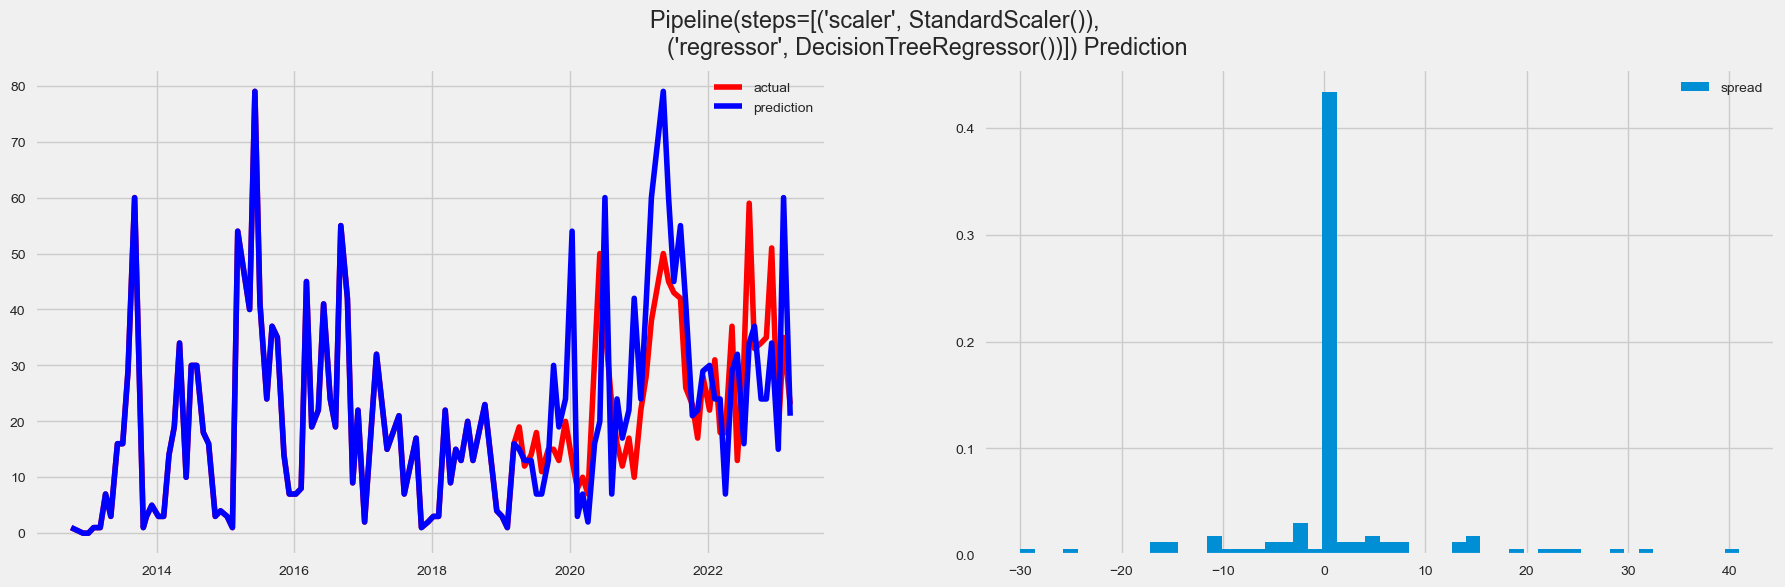

In [43]:
model_report(ModelX, ModelY, decisionTreePipe)

## LinReg

In [44]:
linRegPipe = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
linRegPipe.fit(ModelX_train,Modely_train)
Modely_pred = linRegPipe.predict(ModelX)
mse = mean_squared_error(ModelY, Modely_pred)
rmse = np.sqrt(mse)
df_y_test=pd.DataFrame(Modely_test)
df_y_pred=pd.DataFrame(linRegPipe.predict(ModelX_test))
df_y_pred.index=df_y_test.index
linRegY_df=df_y_test.merge(df_y_pred,how='inner',on='Datetime')
linRegY_df.columns=['y_test','y_pred']
linRegY_df['diff']=linRegY_df['y_test']-linRegY_df['y_pred']
linRegY_df.head()

,y_test,y_pred,diff
Datetime,,,
2019-04-05 09:30:00,19,23.944464,-4.944464
2019-05-03 09:30:00,12,15.543432,-3.543432
2019-06-07 09:30:00,14,14.935448,-0.935448
2019-07-05 09:30:00,18,16.416683,1.583317
2019-08-02 09:30:00,11,9.314753,1.685247


In [45]:
print(f'Total R²: {linRegPipe.score(ModelX, ModelY):.2f}\nTrain R²: {linRegPipe.score(ModelX_train, Modely_train):.2f}\nTest R²: {linRegPipe.score(ModelX_test, Modely_test):.2f}\nmse: {mse:.2f}\nrmse: {rmse}')

Total R²: 0.65
Train R²: 0.78
Test R²: 0.27
mse: 85.84
rmse: 9.265046216258154


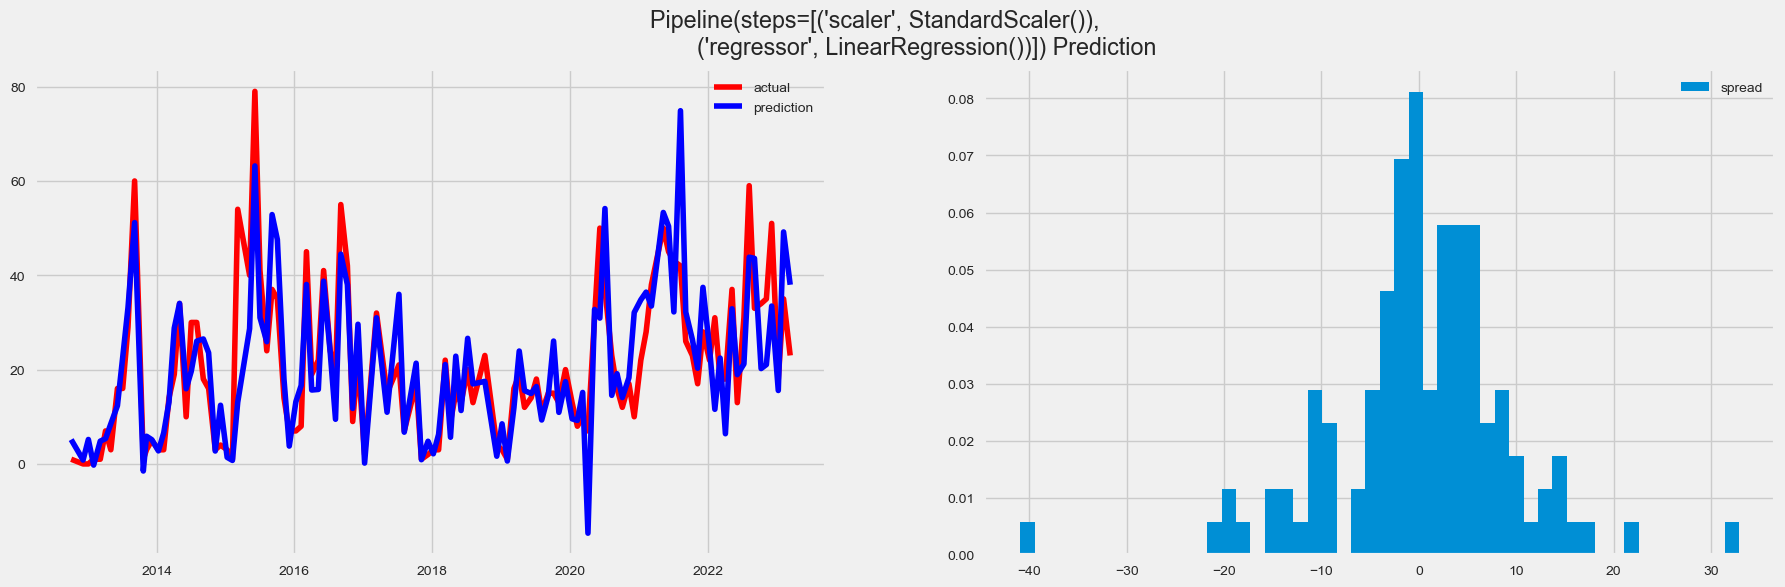

In [46]:
model_report(ModelX, ModelY, linRegPipe)

## LSTM

In [47]:
LSTM_X = np.array(ModelX).reshape(len(ModelX),7,1)
LSTM_y = np.array(ModelY)
LSTMX_train, LSTMX_test, LSTMy_train, LSTMy_test = train_test_split(LSTM_X, LSTM_y, test_size=0.7, random_state=0, shuffle=False)

In [48]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(7, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [49]:
# fit model
model.fit(LSTMX_train, LSTMy_train, batch_size=5, epochs=2000, validation_split=0.2, verbose=0);

In [50]:
# predict the outcome
test_input = np.array(LSTM_X[0])
test_input = test_input.reshape((1, 7, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output)

[[1.6535656]]


In [51]:
# calculate rmse of loss function
train_rmse_scaled = np.sqrt(model.evaluate(LSTMX_train, LSTMy_train, verbose=0))
test_rmse_scaled = np.sqrt(model.evaluate(LSTMX_test, LSTMy_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 9.9414 | Test RMSE: 12.2514


4/4 [==============================] - 0s 2ms/step


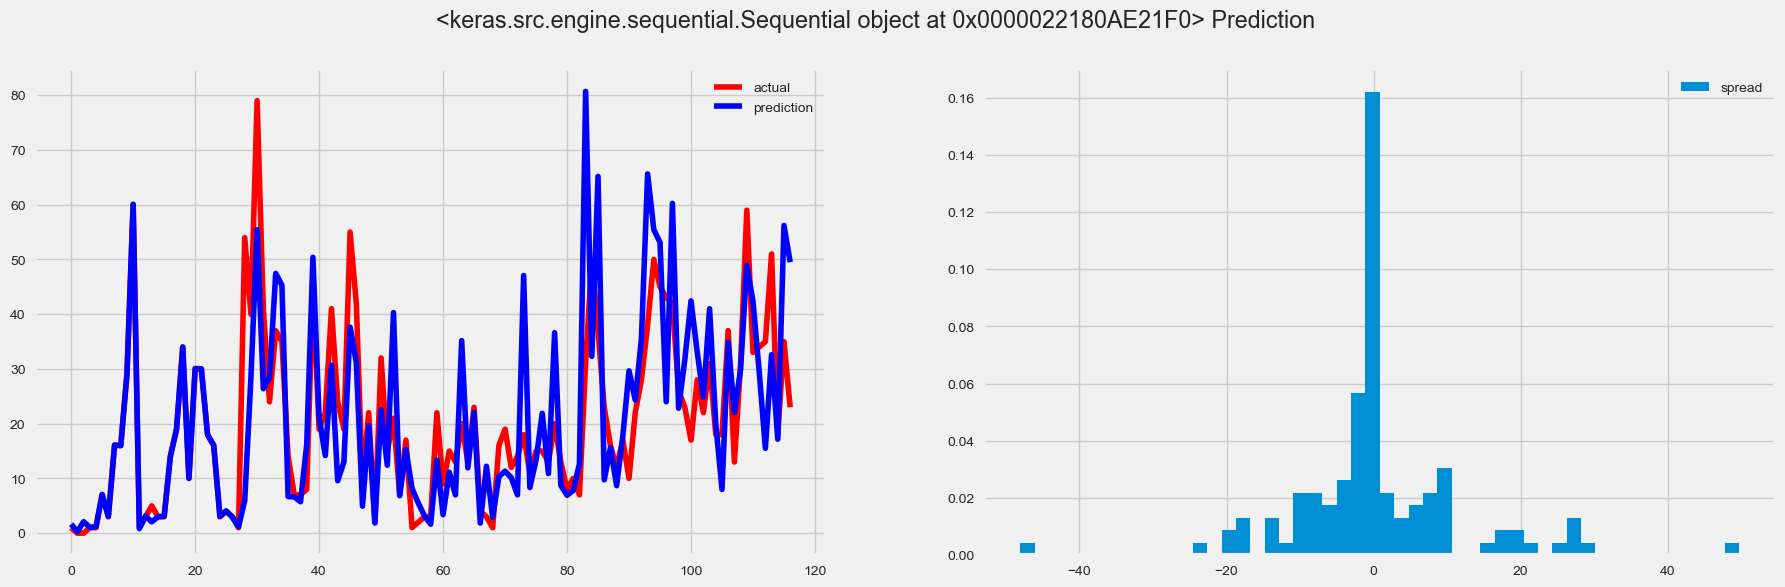

In [52]:
model_report(LSTM_X, LSTM_y, model)